In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/' + scenario + '/'
model_path = '../model/'

In [4]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [5]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [7]:
# Add car sharing, if set in the parameters
car_modes = ['car']
if not np.isnan(params['car_sharing']['asc']):
    car_modes = ['private_car', 'car_sharing']

In [8]:
if scenario.endswith('_equilibrium'):
    sm = stepmodel.read_zippedpickles(model_path + scenario[:-12] + '/' + 'de_pt_los')
else:
    sm = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_pt_los')
sm.segments = segments

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


In [9]:
car = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_road_los')

car_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.90s/it]


In [10]:
# Load zones
try:
    z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path + 'base/' + 'de_zones')

In [11]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.65699140680331

In [12]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

3.0700848170839223

In [13]:
# Make O and D a string
for df in [car.car_los, sm.pt_los]:
    df['origin'] = df['origin'].astype(str)
    df['destination'] = df['destination'].astype(str)

In [14]:
# Define route types for the choice tree
route_types = ['rail_long', 'rail_short',
               'bus', 'coach',
               'air', 'walk'] + car_modes

In [15]:
sm.pt_los['route_type'].unique()

array(['bus', 'rail_short', 'rail_long', 'coach', 'air', 'walk'],
      dtype=object)

In [16]:
# Create a car sharing LoS table, if neccessary
if len(car_modes) > 1:
    to_concat = []
    for c in car_modes:
        los = car.car_los.copy()
        los['route_type'] = c
        los['route_types'] = [(c,) for _ in los.index]
        to_concat.append(los)
    car.car_los = pd.concat(to_concat)

In [17]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

806198

In [18]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [19]:
# Drop columns from previous logit model runs
sm.los.drop([col for col in sm.los.columns if str(col).startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [20]:
# Clean LoS table
#sm.los = sm.los.loc[sm.los['time']>0]
#sm.los = sm.los.loc[sm.los['length']<=1000000]
#len(sm.los)

## Policies

In [21]:
# Set the average speed for high-speed rail long-distance travel
# between major cities (population>100,000)
if not np.isnan(params['rail_long']['hsr_speed']):
    urban_zones = z.zones.loc[(z.zones['urbanisation']==1) & (z.zones['population']>=100000), 'FID']
    hsr_mask = (sm.los['origin'].isin(urban_zones)) & (sm.los['destination'].isin(urban_zones)) \
               & (sm.los['route_type']=='rail_long') & (sm.los['route_types'].apply(lambda t: len(t)==1))
    sm.los.loc[hsr_mask, 'time'] = sm.los.loc[hsr_mask, 'length']/1000 / params['rail_long']['hsr_speed']

In [22]:
# Car-free inner cities
city_pop_share = params['car-free_cities']['population_share_within']
if city_pop_share > 0.1 and city_pop_share <= 1:
    pr_zones = z.zones.loc[z.zones['urbanisation']==1]
    
    # For trips whose destination is a car-free zone
    pr_mask = (sm.los['route_type'].isin(car_modes)) & (sm.los['destination'].isin(pr_zones.index))
    # Add park-and-ride-paths
    pr_paths = sm.los.loc[pr_mask].copy()
    pr_paths['route_types'] = [(t, 'pr') for t in pr_paths['route_type']]
    # Add transfer time and time for local PT based on zone's car-free area
    pr_paths['time'] += params['car-free_cities']['pr_time']
    pr_paths['time'] += np.power(pr_paths['destination'].map(pr_zones['area']), -2) * city_pop_share / 30#km/h
    # Add local PT (parking cost persist)
    for seg in segments:
        pr_paths[seg+'_price'] += params['bus'][1] * params['bus']['multimodal_share']
    sm.los = pd.concat([sm.los, pr_paths]).reset_index(drop=True)
    
    # Inhabitants of car-free zones get the extra time only
    sm.los.loc[(sm.los['route_type'].isin(car_modes))
               & (sm.los['origin'].isin(pr_zones.index)), 'time'
              ] += params['car-free_cities']['pr_time'] * city_pop_share

In [23]:
# Business trips with PT are covered by the employer
# Car trips depend on the setting on b_c in the scenario's estimation results
sm.los.loc[~sm.los['route_type'].isin(car_modes),
           [s+'_price' for s in segments if 'business' in s]] = 0

## Prepare the logit model

Load parameters and generate LoS columns

In [24]:
# Load estimation results
try:
    excel_file = pd.ExcelFile(input_path + 'estimation_results_mode_{}.xlsx'.format(scenario))
except FileNotFoundError:
    excel_file = pd.ExcelFile(input_path + 'estimation_results_mode.xlsx')
params_est = {}
for s in segments:
    params_est[s] = excel_file.parse(s.replace('/', '-'), na_values='#NULL!', index_col=0)

In [25]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
nests = pd.DataFrame(index=route_types + ['rail', 'car', 'root'])
for s in segments:
    nests[s] = ['root']*(len(route_types)+2) + [np.nan]
    for car_mode in car_modes:
        nests.loc[car_mode, s] = 'car' if len(car_modes) > 1 else 'root'
    if 'mu_rail' in params_est[s].index:
        nests.loc['rail_long', s] = 'rail'
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
rail_long,root,root,root,root,root,root,root,root,root,root,root,root
rail_short,root,root,root,root,root,root,root,root,root,root,root,root
bus,root,root,root,root,root,root,root,root,root,root,root,root
coach,root,root,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root,root,root
rail,root,root,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root,root,root


In [26]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(segments))]
# For the nested structure
for s in segments:
    if 'mu_rail' in params_est[s].index:
        sm.logit_scales.loc['rail', s] = 1 / params_est[s].loc['mu_rail', 'Value']
if len(car_modes) > 1:
    sm.logit_scales.loc['car'] = [params['car_sharing']['phi'] for s in segments]
sm.logit_scales

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail_long,1,1,1,1,1,1,1,1,1,1,1,1
rail_short,1,1,1,1,1,1,1,1,1,1,1,1
bus,1,1,1,1,1,1,1,1,1,1,1,1
coach,1,1,1,1,1,1,1,1,1,1,1,1
air,1,1,1,1,1,1,1,1,1,1,1,1
walk,1,1,1,1,1,1,1,1,1,1,1,1
car,1,1,1,1,1,1,1,1,1,1,1,1
root,1,1,1,1,1,1,1,1,1,1,1,1


In [27]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail_short', 'asc_rail_s'),
               ('rail_long', 'asc_rail_l'),
               ('coach', 'asc_coach'),
               ('bus', 'asc_bus'),
               ('air', 'asc_air'),
               ('walk', 'asc_non_motor')]:
    sm.mode_utility.loc[t] = [params_est[s].loc[asc, 'Value'] for s in segments]
for c in car_modes:
    sm.mode_utility.loc[c] = 0 if c!='car_sharing' else params['car_sharing']['asc']
sm.mode_utility.loc['root'] = 0
# Make cars unavailable in households without cars
for seg in [s for s in segments if '_no_car' in s]:
    sm.mode_utility.loc[car_modes[0], seg] = -50
# Make car sharing unavailable in households with cars
if len(car_modes) > 1:
    for seg in [s for s in segments if not '_no_' in s]:
        sm.mode_utility.loc[car_modes[1], seg] = -50
# Correct rail with disutility from perceived delay
#sm.mode_utility.loc['rail_short', [s for s in segments if not 'business' in s]
#                   ] -= params['rail_short']['delay_disutility']
sm.mode_utility

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail_short,1.704139,-2.375221,2.446853,-3.333357,1.403191,-1.149511,1.353823,-3.568824,2.426821,-2.560656,6.520144,-4.130241
rail_long,-0.997140,1.225718,1.210881,-2.415490,-1.925820,-2.256140,-4.600751,-0.654916,1.323842,-0.779980,-5.760192,-4.797553
coach,0.457986,-6.007073,1.255742,-2.808301,2.211445,-1.046938,2.428328,-4.299122,1.330539,-2.863948,-3.012168,-4.706481
bus,2.758570,-1.410165,3.758607,-2.593866,3.102611,0.626983,3.551046,-1.782996,3.964982,-1.251064,8.346136,-2.101935
air,0.000000,0.000000,-5.796481,0.000989,0.000000,0.000000,0.000000,0.000000,-6.651138,8.039841,0.000000,0.000000
walk,-3.923555,-7.509200,-2.875602,-9.595648,-4.791427,-4.623834,-2.732446,-6.340211,-2.395046,-4.926912,-6.093920,-7.096600
car,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
# Performance attributes for mode choice
perf_attrs = [s+'_time' for s in segments] + [s+'_price' for s in segments]

In [29]:
# Beta parameters from calibration data
# IMPORTANT: mind the unit conversion
sm.utility_values = pd.DataFrame({s: [0 for _ in perf_attrs] for s in segments},
                                 index=[str(a) for a in perf_attrs], dtype=float)
#sm.utility_values.loc['waiting_time'] = [params_est[seg].loc['b_wt', 'Value'] for seg in segments]
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for s in segments:
    sm.utility_values.loc[s+'_time', s] = params_est[s].loc['b_t', 'Value']
    try:
        sm.utility_values.loc[s+'_price', s] = params_est[s].loc['b_c', 'Value']
    except KeyError: # Business has no b_c
        sm.utility_values.loc[s+'_price', s] = 0
sm.utility_values

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
commuting_no_car_time,-0.025094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commuting_car_time,0.000000,-0.025840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_no_car_time,0.000000,0.000000,-0.052627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_car_time,0.000000,0.000000,0.000000,-0.019877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_no_car_time,0.000000,0.000000,0.000000,0.000000,-0.101543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,-0.044622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.148247,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.083002,0.000000,0.000000,0.000000,0.000000
leisure_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.046437,0.000000,0.000000,0.000000
leisure_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.032593,0.000000,0.000000


In [30]:
# Generate damped cost (see cal20)
c = params['estimation'].to_dict()
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    return (beta*theta[0]*np.power(np.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*np.power(np.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*np.power(np.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [31]:
# Apply the spline function
for s in tqdm(segments):
    c1 = c['c1_time_'+s]
    c2 = c['c2_time_'+s]
    beta = sm.utility_values.loc[s+'_time', s]
    sm.los[s+'_time'] = spline(sm.los['time']*60, beta, c1*60, c2*60)
    # Make beta_t one because it is now included in the LoS attribute 't'
    sm.utility_values.loc[s+'_time', s] = 1

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.80it/s]


In [32]:
# Divide price by income change (i.e. price sensitivity)
for s in segments:
    sm.los[s + '_price'] /= sm.los['origin'].map(z.zones.set_index(
        z.zones['FID'].astype(str))['urbanisation']).map(params['income_change'])

## Mode Choice

In [33]:
# Build the utility column in sm.los for each segment
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.12s/it]


In [34]:
# Run the logit model to calculate probabilities
sm.step_logit(workers=4)

c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths.rename(columns={(segment, 'utility'): 'utility'}, inplace=True)
c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths.rename(columns={(segment, 'utility'): 'utility'}, inplace=True)
c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [35]:
sm.probabilities.head(3)

route_type,origin,destination,segment,root,rail,car,walk,air,coach,bus,rail_short,rail_long
0,100410100,100410511,accompany_car,1,0.0,9.748173e-01,2.941171e-04,0.0,0.0,0.006629,0.018259,0.0
1,100410100,100410511,accompany_no_car,1,0.0,1.186785e-25,2.460236e-07,0.0,0.0,0.138230,0.861770,0.0
2,100410100,100410511,business_car,1,0.0,9.328959e-01,3.639444e-05,0.0,0.0,0.030195,0.036873,0.0


In [36]:
sm.utilities.head(3)

route_type,origin,destination,segment,root,rail,car,walk,air,coach,bus,rail_short,rail_long
0,100410100,100410511,accompany_car,-1.737631,-inf,-1.763136,-9.869164,-inf,-inf,-6.753907,-5.740706,-inf
1,100410100,100410511,accompany_no_car,4.329518,-inf,-53.063861,-10.888320,-inf,-inf,2.350679,4.180751,-inf
2,100410100,100410511,business_car,-0.530467,-inf,-0.599929,-10.751562,-inf,-inf,-4.030542,-3.830754,-inf


In [37]:
# Set the probability for choosing P&R into a car-free city
# emulate a P&R model with the probability given as population share
if city_pop_share > 0.1 and city_pop_share <= 1:
    sm.los.columns = [str(c) for c in sm.los.columns]
    pr_mask = (sm.los['route_type'].isin(car_modes)) & (sm.los['destination'].isin(pr_zones.index))
    prob_sum = sm.los.loc[pr_mask].groupby(['origin', 'destination']).agg(
        {str((seg, 'probability')): 'sum' for seg in segments})
    is_pr = pr_mask & (sm.los['route_types'].apply(lambda t: 'pr' in t))
    not_pr = pr_mask & ~(sm.los['route_types'].apply(lambda t: 'pr' in t))
    for seg in segments:
        sm.los.loc[is_pr, str((seg, 'probability'))] = pd.merge(
            sm.los.loc[is_pr, ['origin', 'destination']], prob_sum[str((seg, 'probability'))],
            how='left', left_on=['origin', 'destination'], right_index=True
        )[str((seg, 'probability'))] * city_pop_share
        sm.los.loc[not_pr, str((seg, 'probability'))] = pd.merge(
            sm.los.loc[not_pr, ['origin', 'destination']], prob_sum[str((seg, 'probability'))],
            how='left', left_on=['origin', 'destination'], right_index=True
        )[str((seg, 'probability'))] * (1 - city_pop_share)
    sm.los.rename(columns={c: eval(c) for c in sm.los.columns if ',' in c}, inplace=True)

In [38]:
# Validate that probabilities sum up to one
od = sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1)
print(od.mean())
print(od.max())
print(od.min())

1.0
1.0000000000000002
0.9999999999999999


## Save model

In [39]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.pt_los = sm.los.loc[~sm.los['route_type'].isin(car_modes)].reset_index(drop=True)
sm.car_los = sm.los.loc[sm.los['route_type'].isin(car_modes)].reset_index(drop=True)
sm.to_zippedpickles(model_path + scenario + '/' + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities',
    'car_los', 'pt_los'])

car_los: 100%|█████████████████████████████████████████████████████████████████████████| 15/15 [01:15<00:00,  5.00s/it]


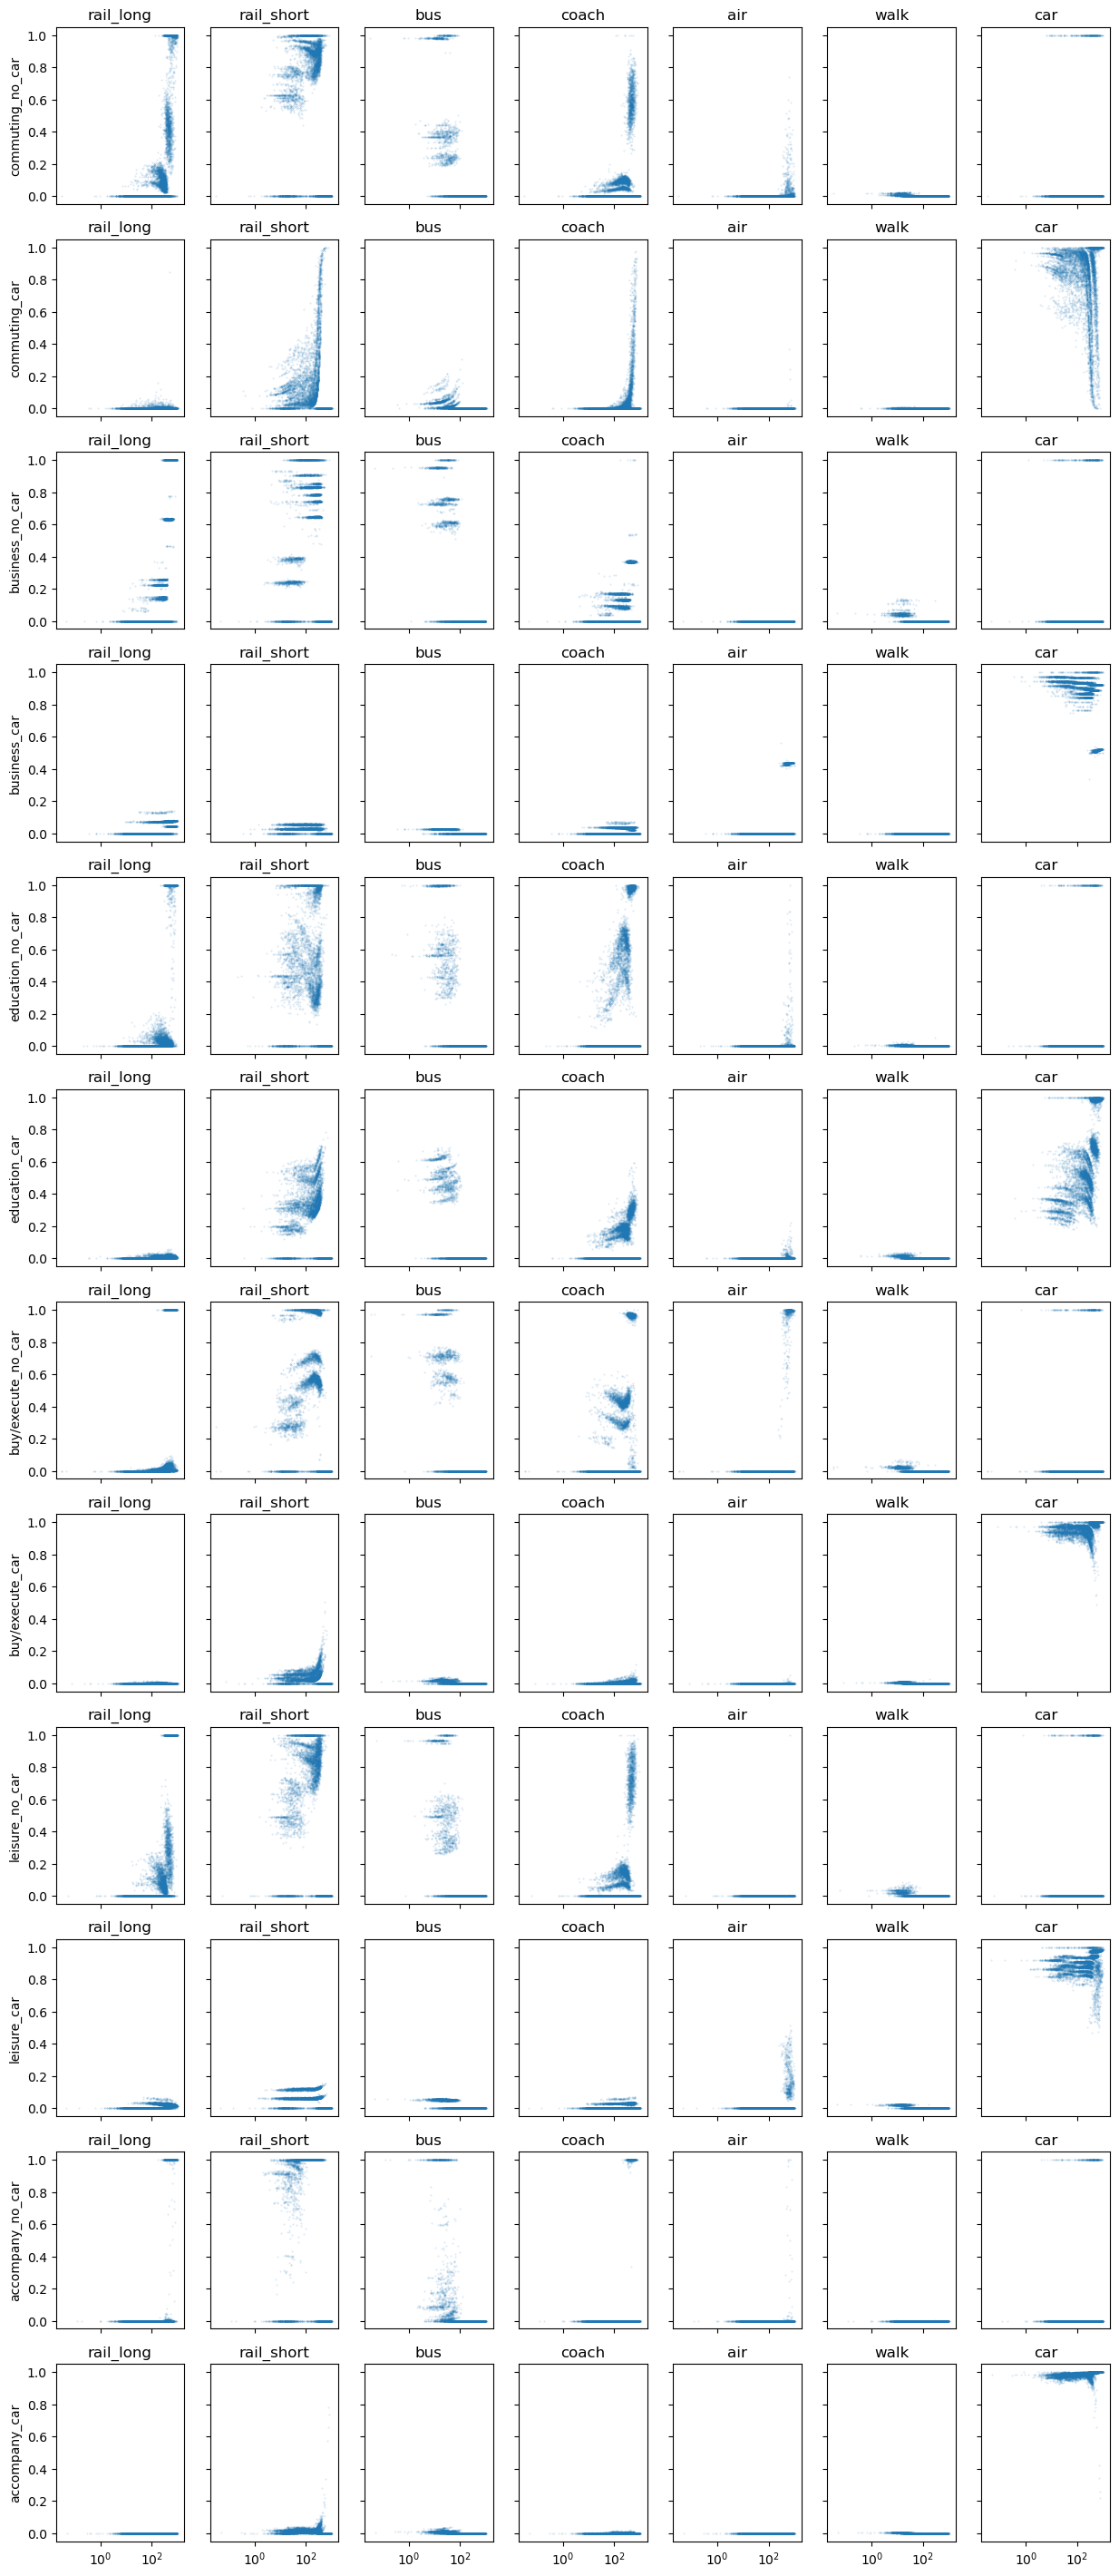

In [86]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.sample(max(int(len(sm.probabilities)**0.5), 100000)).merge(
        car.car_los[['origin', 'destination', 'length']],
        on=['origin', 'destination'],
        how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(15,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.2, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].set_title(mode)
            ax[i,0].set_ylabel(seg)
            ax[i,j].set_xscale('log')
    plt.savefig(output_path + 'probability_distribution.png', dpi=400)

In [ ]:
# Time
if manual:
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,16))
    c_dict = {'rail_short': 'blue', 'rail_long': 'pink', 'bus': 'orange',
              'coach': 'yellow', 'car': 'red', 'air': 'black'}
    sm.los['length'] /= 1000
    for m in c_dict.keys():
        mask = sm.los['route_type']==m
        size = min(5000, len(sm.los.loc[mask]))
        sm.los.loc[mask].sample(size).plot(
            ax=ax[0], kind='scatter', x='length', y='time', s=.9, c=c_dict[m], alpha=.5, label=m)
        mask = (sm.los['route_type']==m) & (sm.los['length']<30)
        size = min(5000, len(sm.los.loc[mask]))
        sm.los.loc[mask].sample(size).plot(
            ax=ax[1], kind='scatter', x='length', y='time', s=.9, c=c_dict[m], alpha=.5, label=m)
    ax[0].legend()
    sm.los['length'] *= 1000

In [ ]:
# Prices
if manual:
    fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(16,9), sharex='all', sharey='all')
    c_dict = {'rail_short': 'blue', 'rail_long': 'pink', 'bus': 'orange',
              'coach': 'yellow', 'car': 'red', 'air': 'black'}
    sm.los['length'] /= 1000
    for i, car in {0: '_no_car', 1: '_car'}.items():
        for j, p in zip(range(len(purposes)), purposes):
            for m in c_dict.keys():
                mask = (sm.los['route_type']==m) & (sm.los['length']<30)
                sample = sm.los.loc[mask].sample(min(5000, len(sm.los.loc[mask])))
                ax[i,j].scatter(sample['length'], sample[p+car+'_price'],
                                s=.7, c=c_dict[m], alpha=.3, label=m)
            ax[i,j].set_title(p+car)
    ax[0,0].legend()
    sm.los['length'] *= 1000

### Save composite generalised cost / logsum
For sequential destination choice modelling

In [87]:
# define the logsum function with numpy
def logsum(v_list):
    # Given a list of pre-calculated negative utilities
    return np.log(np.sum([np.exp(-1 * v) for v in v_list]))

In [88]:
# Calculate the logsum of cost parameters
if scenario != 'base' and not os.path.exists(output_path + 'mode_choice_od_composite_cost.csv'):
    # Make price utility negative by multiplying with betas (time already is)
    for s in segments:
        try:
            sm.los[s + '_price'] *= params_est[s].loc['b_c', 'Value']
        except KeyError: # business does not have beta for prices
            sm.los[s + '_price'] = 0
    # Calculate composite cost for price and time
    comp_cost = sm.los.groupby(['origin', 'destination']).agg(
        {col: logsum for col in perf_attrs})
    # Sum up generalised cost
    for s in segments:
        attrs = [s+'_time', s+'_price']
        comp_cost[s] = comp_cost[attrs].sum(axis=1)
        comp_cost.drop(attrs, axis=1, inplace=True)
    # Save
    comp_cost.to_csv(output_path + 'mode_choice_od_composite_cost.csv')

In [ ]:
# Calculate the logsum for utility
#comp_u = sm.los.groupby(['origin', 'destination']).agg(
#    {(s, 'utility'): logsum for s in segments})
# Save it
#comp_u.columns = [c.split("'")[1] for c in comp_u.columns]
#comp_u.to_csv(output_path + 'mode_choice_od_composite_utility.csv')